# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [7]:
# create dataframe that merges company df_offers with customer df_transactions
df_merged = df_offers.merge(df_transactions, how='inner', on='offer_id')
df_merged.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [79]:
# create dataframe that pivots company df_offers with customer df_transactions 
# used fill_value keyword to add 0 for all non-values in dataset
pivoted_df = pd.pivot_table(df_merged, values='n', index='customer_name', columns='offer_id', fill_value=0)
pivoted_df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

**Answer**: For unsupervised machine learning, the K Means clustering algorithm for grouping a dataset is most commonly used. In K Means clustering, each observation/datapoint is assigned to a given cluster where the sum of squares (SS) distance of the observation/datapoint to the cluster's assigned 'k' cluster centriods is minimized. Therefore, values of SS that represent better clusterings will minimize the distance between each point and the 'k' cluster centriods, so values closer to or equal to 0.

#### Apply the [`KMeans`] clustering method from scikit-learn to this matrix

In [27]:
# import necessary modules
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

In [14]:
# Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)
x_cols = pivoted_df.as_matrix()
x_cols

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]])

#### Construct a plot showing SS for each K (2≤K≤10) and pick K using this plot  

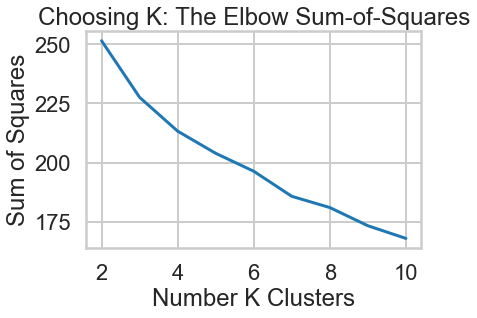

In [51]:
# create a possible_K variable for 2≤K≤10
possible_K = range(2,11)

# create a sum of squares (SS) list variable to store each SS per K value
SS = [] 

# itereate over each K value in possible_K
for k in possible_K:
    
    # create a KMeans cluster model for k
    model = KMeans(n_clusters=k) 
    
    # calculate cluster-distance space with fit/transform model to the x_cols sample values 
    model.fit_transform(x_cols)
    
    # add calculated SS value (.inertia_) to SS list
    SS.append(model.inertia_) 

plt.plot(possible_K, SS)
plt.title("Choosing K: The Elbow Sum-of-Squares")
plt.xlabel("Number K Clusters")
plt.ylabel("Sum of Squares")
plt.show()

**Conclusion**: Based off of the The Elbow Sum-of-Squares chart for choosing the most optimal K, the elbow point (where the plot starts descending much more slowly) appears to be around **K=3**.

#### Make a bar chart showing the number of points in each cluster for k-means under the best  K(=3) .

In [41]:
# Create a KMeans model for ideal K=3

# create model_ideal
model_ideal = KMeans(n_clusters=3)
    
# fit model to samples
model_ideal.fit(x_cols)

# create labels for model_ideal
labels = model_ideal.labels_

Text(0,0.5,'# Points')

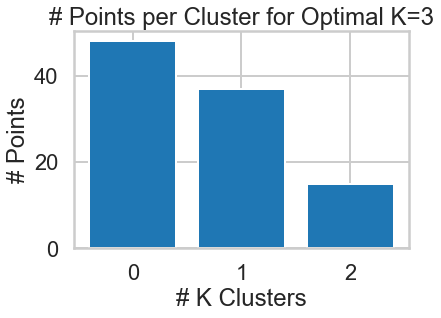

In [42]:
# calculate number of points in each K cluster for K<4
x,y = zip(*Counter(labels).most_common())

# bar plot points per # K clusters for K<4
plt.bar(x, y)
plt.title("# Points per Cluster for Optimal K=3")
plt.xlabel("# K Clusters")
plt.ylabel("# Points")

**Challenges**: Choosing the 'optimal' K value based off of a graph seems largely subjective, given a certain range of 'K'-values. Therefore, choosing the 'optimal' K value seems to be dependent on one's interpretation of where Sum-of-Squares line 'begins to decrease the most.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

#### Construct a series of silhouette plots

In [45]:
# Import necesary modules
from __future__ import print_function
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
print(__doc__)

Automatically created module for IPython interactive environment


**Review of Silhouette Coefficient and Silhouette Scores**: 
- silhouette coefficient can range from [-1, 1]
- silhouette_score gives the average value for all the samples - gives a perspective into the density and separation of the formed # clusters

For n_clusters = 2 The average silhouette_score is : 0.4440694624637262
For n_clusters = 3 The average silhouette_score is : 0.6391477934585507
For n_clusters = 4 The average silhouette_score is : 0.8395302547773104
For n_clusters = 5 The average silhouette_score is : 0.6427685988446565
For n_clusters = 6 The average silhouette_score is : 0.44837497124826164


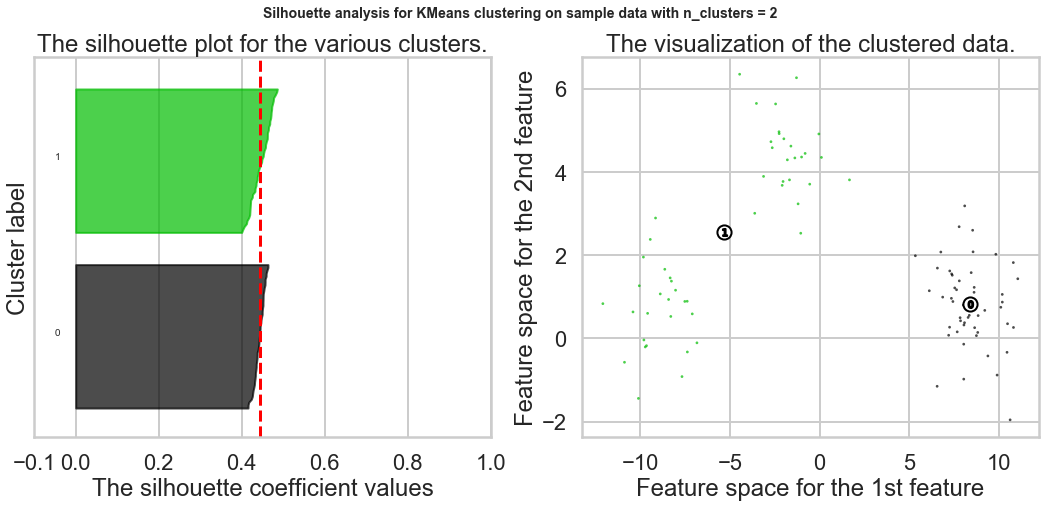

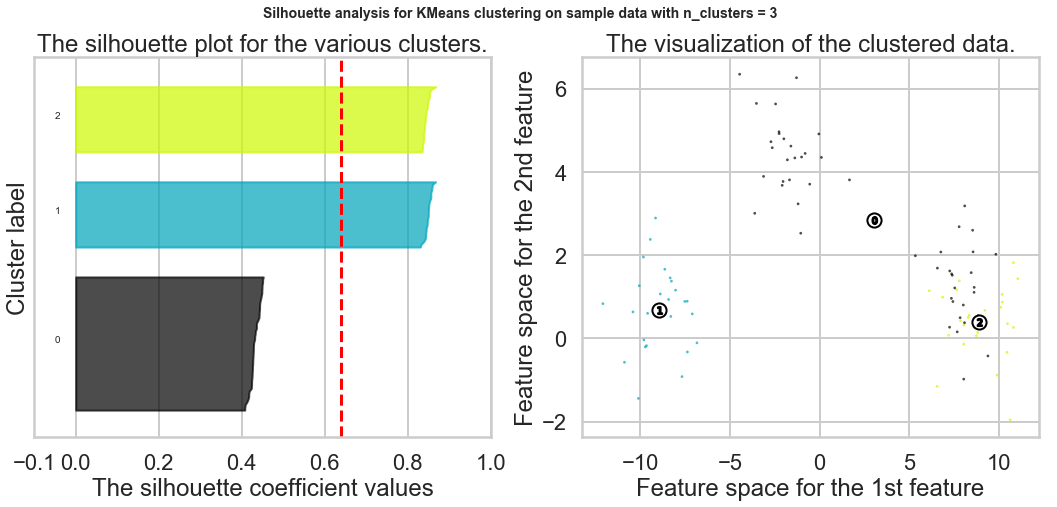

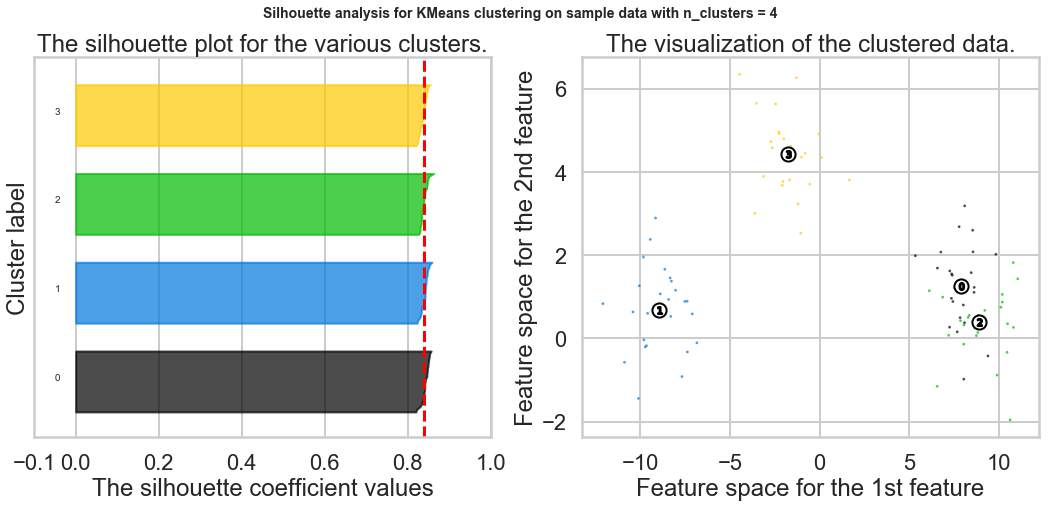

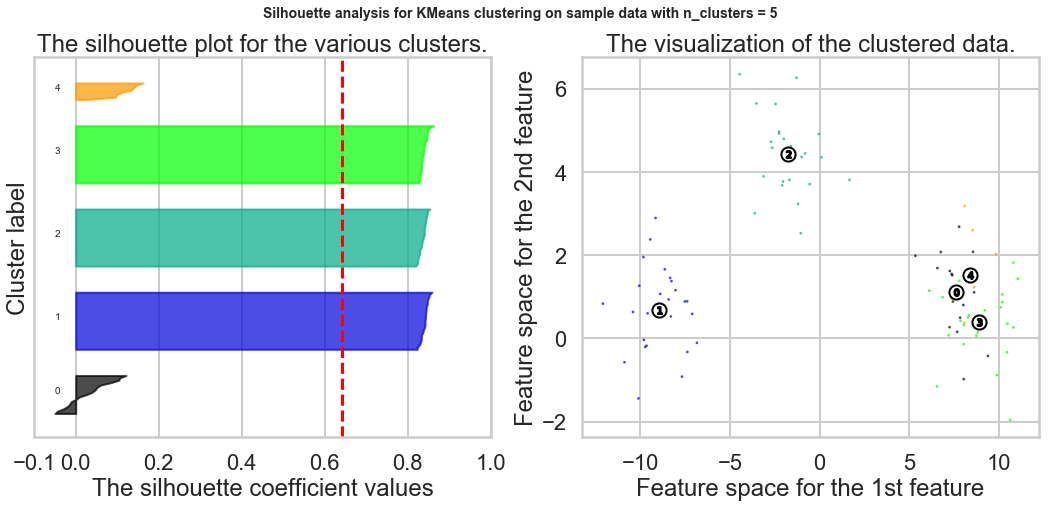

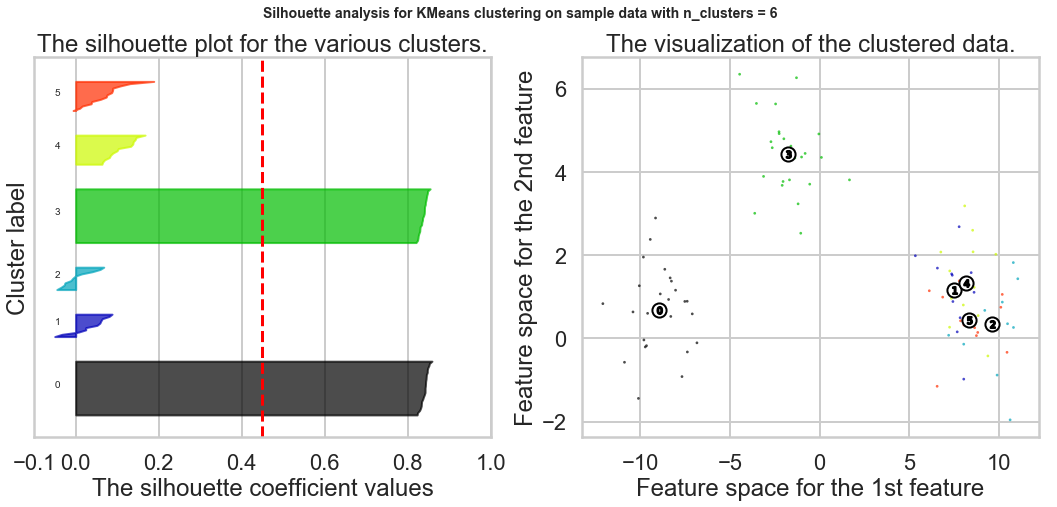

In [73]:
# Generate the sample data from make_blobs: 1 distinct cluster with 3 clusters placed close together
# source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# for reproducibility:
X, y = make_blobs(n_samples=100,
                  n_features=32,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

# define the number of range clusters
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    #1st subplot: Silhouette Plot
    
    # define the silhouette coefficient [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # use (n_clusters+1)*10 to inserting blank space between silhouette plots of individual clusters
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # initialize the KMean clusterer with n_clusters 'k' and a random generator seed of 10 for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    # fit_predict model to X
    cluster_labels = clusterer.fit_predict(X)

    # calculate the silhouette_score for n_clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        """Aggregate the silhouette scores for samples belonging to cluster i and sort them"""
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #2nd subplot: Actual Clusters Formed
    
    # plot actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # label the clusters
    centers = clusterer.cluster_centers_
    
    # draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Text(0,0.5,'Average Silhouette Score')

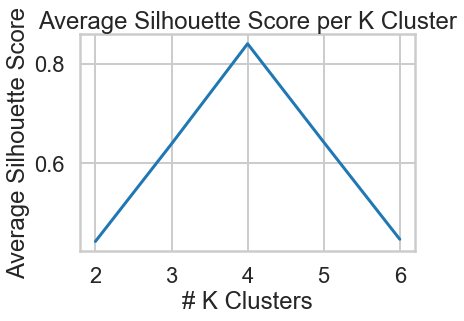

In [75]:
# Graph the average Silhouette Score for each K value
x = 2, 3, 4, 5, 6
y = 0.4440694624637262, 0.6391477934585507, 0.8395302547773104, 0.6427685988446565, 0.44837497124826164
plt.plot(x, y)
plt.title('Average Silhouette Score per K Cluster')
plt.xlabel("# K Clusters")
plt.ylabel("Average Silhouette Score")

**Conclusion**: Based off of the Choosing K: The Silhouette Method, *K = 4* has the most optimal silhouette score. This number is slightly different than the chosen *K = 3* from the The Elbow Sum-of-Squares chart, but as stated above, the chart was largely subjective regarding when the slow decreased the most, so the Silhouette Method appears to be more direct in its presentation of most optimal K than the Elbow Method.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [70]:
# Import necessary modules
from sklearn.decomposition import PCA

In [96]:
# Create PCA model to reduce dimensionality of cluster data to 2
model_pca = PCA(n_components=2)

# Create a Tansform variable with PCA model
transform = model_pca.fit_transform(x_cols)

# Get new clustering for k=4
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_cols)

# Create a subdataframe 
pca_df = pd.DataFrame(pivoted_df.index)
pca_df['cluster'] = kmeans.labels_

# Get the first(X) and second(Y) principal components
x = transform[:,0]
y = transform[:,1]

# Add X and Y to subdataframe
pca_df['pc1'] = x
pca_df['pc2'] = y

pca_df.sample(10)

,customer_name,cluster,pc1,pc2
77,Rogers,0,0.377123,-0.791758
31,Gutierrez,0,0.346529,-0.288514
96,Wilson,2,0.688224,-0.013688
22,Evans,0,-0.371485,-0.348007
18,Cruz,2,0.736155,0.117752
24,Flores,3,-0.239706,0.911844
1,Allen,0,-0.287539,0.044715
73,Rivera,2,0.564060,0.056861
3,Bailey,2,0.699477,-0.022542
30,Green,0,0.292635,0.066399


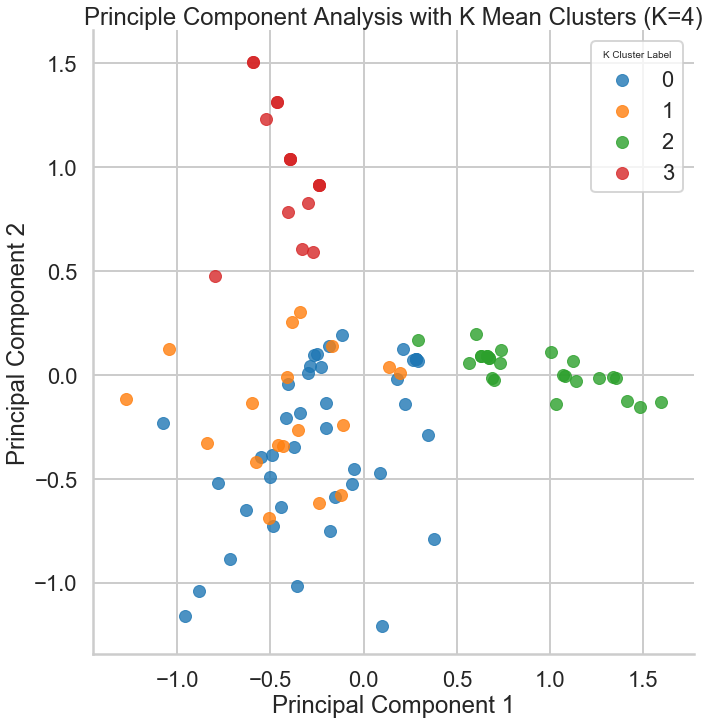

In [98]:
# Plot a scatterplot of the `x` vs `y` columns
sns.lmplot(data=pca_df, x='pc1', y='pc2', hue='cluster', height=10, fit_reg=False, legend=None)
plt.title('Principle Component Analysis with K Mean Clusters (K=4)')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='K Cluster Label')
plt.show()

**Preliminary Conclusion**: Despite the Silhouette Method clearly showing that K = 4 has the most optimal silhouette score, there is quite a bit of overlap between the clusters for the Principle Components. I will re-run the same methods for K = 3, which was shown to be most optimal by the Elbow Method, to assess if there is still substanial overlap. 

In [99]:
# Get new clustering for k=3
kmeans_retry = KMeans(n_clusters=3)
kmeans_retry.fit(x_cols)

# Create a subdataframe 
pca_df_retry = pd.DataFrame(pivoted_df.index)
pca_df_retry['cluster'] = kmeans_retry.labels_

# Get the first(X) and second(Y) principal components
x_retry = transform[:,0]
y_retry = transform[:,1]

# Add X and Y to subdataframe
pca_df_retry['pc1'] = x_retry
pca_df_retry['pc2'] = y_retry

pca_df_retry.sample(10)

,customer_name,cluster,pc1,pc2
69,Ramirez,0,-0.187206,0.140621
45,Lee,0,-0.718778,-0.885306
16,Cooper,0,-0.406276,-0.045771
0,Adams,2,1.007580,0.108215
7,Bennett,2,0.661732,0.090308
90,Turner,0,-0.632199,-0.651152
19,Davis,0,-0.349057,-0.267081
30,Green,2,0.292635,0.066399
57,Murphy,2,0.266997,0.073461
9,Brown,2,1.079827,-0.007488


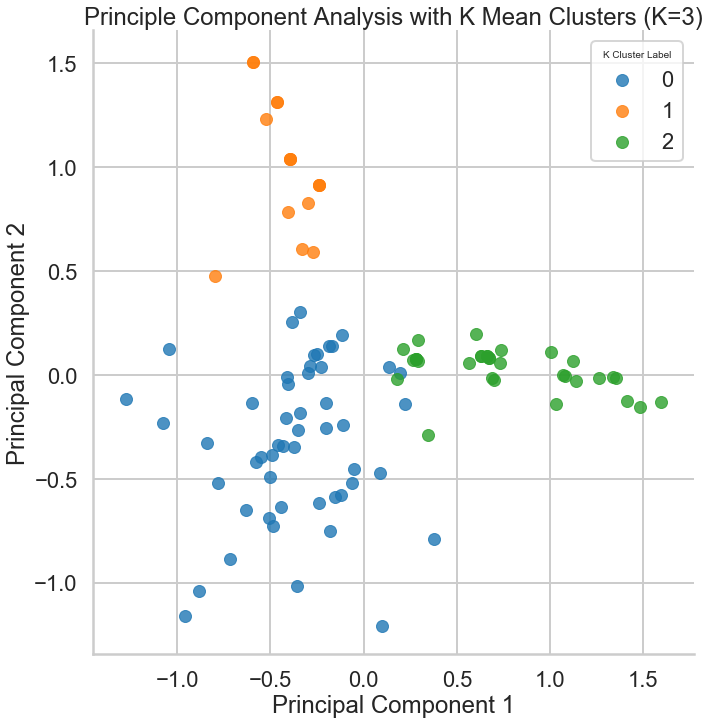

In [100]:
# Plot a scatterplot of the `x` vs `y` columns
sns.lmplot(data=pca_df_retry, x='pc1', y='pc2', hue='cluster', height=10, fit_reg=False, legend=None)
plt.title('Principle Component Analysis with K Mean Clusters (K=3)')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='K Cluster Label')
plt.show()

**Final Conclusion**: At K=3, there is substantially less overlap between the clusters for each Principal Component. Thus, K=3 is more optimal than K=4 because it produces more defined, predictable clusters that has a lower incidence of false positive and false negative classifications.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [106]:
# Import necessary modules
import sklearn.decomposition

In [110]:
# Initialize a new PCA model with a default number of components.
pca = sklearn.decomposition.PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [111]:
pca.explained_variance_

array([4.03612607e+02, 3.51994337e+02, 2.57520574e+02, 2.29135277e+00,
       1.93506510e+00, 1.82833036e+00, 1.76446161e+00, 1.72580431e+00,
       1.51659835e+00, 1.45463841e+00, 1.33970965e+00, 1.19991392e+00,
       1.15124766e+00, 1.09011194e+00, 1.01835674e+00, 9.92274251e-01,
       8.73433570e-01, 7.97491581e-01, 7.90207369e-01, 7.41134719e-01,
       7.02605714e-01, 6.11474781e-01, 5.96842379e-01, 5.40378844e-01,
       5.09889729e-01, 4.61226005e-01, 4.26225069e-01, 4.06024527e-01,
       3.53440738e-01, 3.23993608e-01, 2.76381389e-01, 2.35686123e-01])

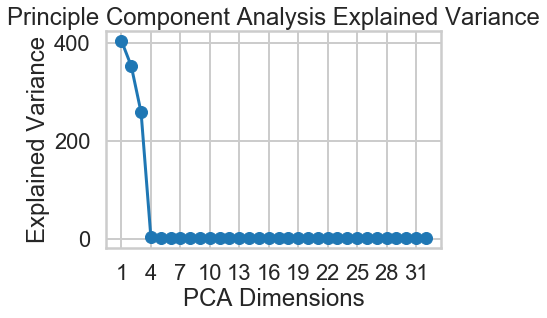

In [129]:
# Plot the `explained_variance_` field 
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'o-')
plt.title('Principle Component Analysis Explained Variance')
plt.xlabel('PCA Dimensions')
plt.xticks(np.arange(1, len(pca.explained_variance_) + 1, step=3))
plt.ylabel('Explained Variance')
plt.show()

**Answer**: Based off of the Explained Variance plot, the elbow for this data appears between PCA=3 to PAC=4. This is where there is the steepest descent for the relationship occurs followed by a generally flat, unsloped, trend thereafter.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [159]:
# Import necessary modules
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

In [160]:
# define an empty dictionary var to store each result for each algorithm
all_alg_metrics = {}

#### Affinity Propagation

In [161]:
# Create an Affinity Propagation instance
aff_prog = AffinityPropagation()

# Fit data to model
aff_prog.fit(x_cols)

# Calculate the Silhouette Score
aff_prog_sil_score = silhouette_score(x_cols, aff_prog.labels_)

# Add to all_alg_metrics dictionary for Affinity Progation
all_alg_metrics['Affinity Propagation'] = aff_prog_sil_score
all_alg_metrics

{'Affinity Propagation': 0.12346523604478911}

#### Spectral Clustering

In [162]:
# Create an Spectral Clustering instance
spec_clus = SpectralClustering()

# Fit data to model
spec_clus.fit(x_cols)

# Calculate the Silhouette Score
spec_clus_sil_score = silhouette_score(x_cols, spec_clus.labels_)

# Add to all_alg_metrics dictionary for Spectral Clustering
all_alg_metrics['Spectral Clustering'] = spec_clus_sil_score
all_alg_metrics 

{'Affinity Propagation': 0.12346523604478911,
 'Spectral Clustering': 0.049647176411099544}

#### Agglomerative Clustering

In [163]:
# Create an Agglomerative Clustering instance
agg_clus = AgglomerativeClustering()

# Fit/ Predict data to model
agg_clus.fit(x_cols)

# Calculate the Silhouette Score
agg_clus_sil_score = silhouette_score(x_cols, agg_clus.labels_)

# Add to all_alg_metrics dictionary for Agglomerative Clustering
all_alg_metrics['Agglomerative Clustering'] = agg_clus_sil_score
all_alg_metrics 

{'Affinity Propagation': 0.12346523604478911,
 'Spectral Clustering': 0.049647176411099544,
 'Agglomerative Clustering': 0.08258017823184984}

#### DBSCAN

In [164]:
# Create an DBSCAN instance
dbscan = DBSCAN(min_samples=3,eps=1)

# Fit/ Predict data to model
dbscan.fit(x_cols)

# Calculate the Silhouette Score
dbscan_sil_score = silhouette_score(x_cols, dbscan.labels_)

# Add to all_alg_metrics dictionary for DBSCAN
all_alg_metrics['DBSCAN'] = dbscan_sil_score
all_alg_metrics 

{'Affinity Propagation': 0.12346523604478911,
 'Spectral Clustering': 0.049647176411099544,
 'Agglomerative Clustering': 0.08258017823184984,
 'DBSCAN': 0.03831616142184094}

In [166]:
print('%-25s : %2.4f silhouette score' % ('Affinity Propagation',     aff_prog_sil_score))
print('%-25s : %2.4f silhouette score' % ('Spectral Clustering',      spec_clus_sil_score))
print('%-25s : %2.4f silhouette score' % ('Agglomerative Clustering', agg_clus_sil_score))
print('%-25s : %2.4f silhouette score' % ('DBSCAN',                   dbscan_sil_score))

Affinity Propagation      : 0.1235 silhouette score
Spectral Clustering       : 0.0496 silhouette score
Agglomerative Clustering  : 0.0826 silhouette score
DBSCAN                    : 0.0383 silhouette score


**Conclusion**: The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Based off of the Silhouette Scores calculated by each algorithm, the Affinity Propagation performed the most accurately. Spectral and Agglomerative Clustering methods seem to denote poor clusting with observations closer to the decision boundary and Spectral Clustering followed by DBSCAN performed poorly in comparrison to Affinity Propagation.